# How to Use XGBoost for Time Series Forecasting

[blog post](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)

<br>
<br>


# Imports

In [3]:
import os

import data_science_tools as tools

from matplotlib.pylab import plt
import pandas as pd
import numpy as np
import sklearn.metrics
import xgboost

import src
%matplotlib inline

In [7]:
tools.config.initialize()

# Parameters

In [8]:
N_INPUT = 5
N_FORECAST = 1

# Raw Data


[Dataset (daily-total-female-births.csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv)

[Description (daily-total-female-births.names)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.names)


In [9]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv'
df_daily_female_births = pd.read_csv(url, header=0, index_col=0)
df_daily_female_births.columns = [
    c.lower() for c in df_daily_female_births.columns
]

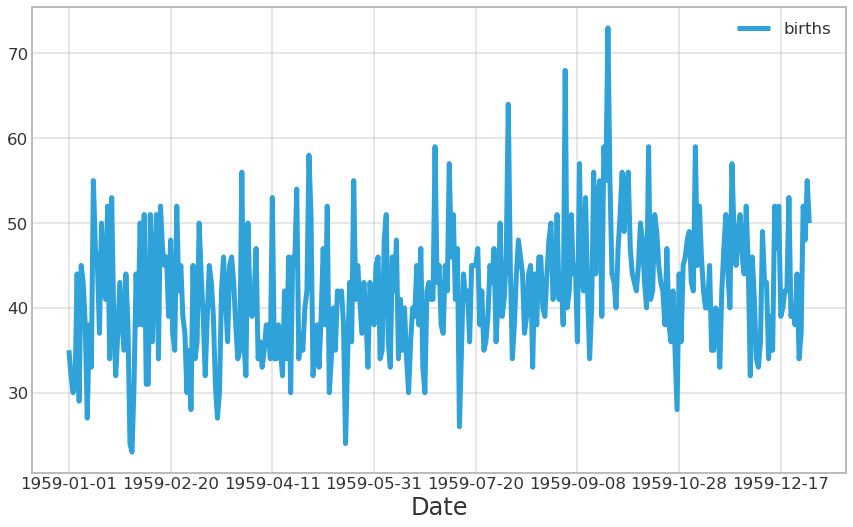

In [10]:
df_daily_female_births.plot()

# Process Data

In [11]:
def series_to_supervised(data, n_in=N_INPUT, n_out=N_FORECAST, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    names = []

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names.extend([f'input_{c}_{i}' for c in df.columns])
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names.extend([f'forecast_{c}_{i}' for c in df.columns])

    # put it all together
    # agg = pd.DataFrame(cols, index=names).T
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
def make_dataset(data, filename):
    df_input = series_to_supervised(data)
    df_input.to_csv(
        os.path.join(src.config.DATA_DIR, 'processed', filename),
    )
    return df_input

In [13]:
df_train = make_dataset(df_daily_female_births, 'how_to_user_xgboost_training_data.csv')

# Model

In [14]:
def build_model():
    model = xgboost.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000,
    )
    return model

In [15]:
model = build_model()

# Training



In [16]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [17]:
def walk_forward_validation(data, model, n_test, metric):
    """ Walk-forward validation for univariate data """
    predictions = []
    
    # split dataset
    train_orig, test = train_test_split(data, n_test)
    
    train = train_orig.copy()
    
    history = list(train[:-N_FORECAST])
    
    for i in range(len(test)):
        trainX, trainy = train[:, :-N_FORECAST].copy(), train[:, -N_FORECAST:].copy()

        # fit model
        model.fit(trainX, trainy)

        # predict
        testX, testy = test[i, :-N_FORECAST], test[i, -N_FORECAST:] 
        predy = model.predict(testX.reshape(1, -1))
        predictions.append(predy)

        print(f'Day {i} expect={testy} predict={predy}')

        # add day to training
        train = np.concatenate((train, np.array([test[i]]))).copy()    
        
    testX, testy = test[:, :-1], test[:, -1]
    # estimate prediction error
    error = metric(testy, predictions)
    return {
        'error': error,
        'testX': testX,
        'testy': testy,
        'predictions': np.array(predictions),
    }


In [43]:
results = walk_forward_validation(
    data=df_train.values,
    model=model,
    n_test=100,
    metric=sklearn.metrics.mean_absolute_error,
)

Day 0 expect=[73.] predict=[37.91803] error=35.08197021484375
Day 1 expect=[55.] predict=[59.74679] error=4.746791839599609
Day 2 expect=[44.] predict=[41.16116] error=2.8388404846191406
Day 3 expect=[43.] predict=[62.697094] error=19.697093963623047
Day 4 expect=[40.] predict=[43.97048] error=3.9704818725585938
Day 5 expect=[47.] predict=[50.644005] error=3.6440048217773438
Day 6 expect=[51.] predict=[38.594593] error=12.405406951904297
Day 7 expect=[56.] predict=[37.110588] error=18.88941192626953
Day 8 expect=[49.] predict=[47.152954] error=1.8470458984375
Day 9 expect=[54.] predict=[37.387444] error=16.61255645751953
Day 10 expect=[56.] predict=[40.94752] error=15.052478790283203
Day 11 expect=[47.] predict=[48.96565] error=1.9656486511230469
Day 12 expect=[44.] predict=[54.14532] error=10.145320892333984
Day 13 expect=[43.] predict=[45.831238] error=2.83123779296875
Day 14 expect=[42.] predict=[43.898945] error=1.8989448547363281
Day 15 expect=[45.] predict=[41.993004] error=3.006

# Results

In [44]:

y_test = results['testy']
y_pred = results['predictions'].ravel()

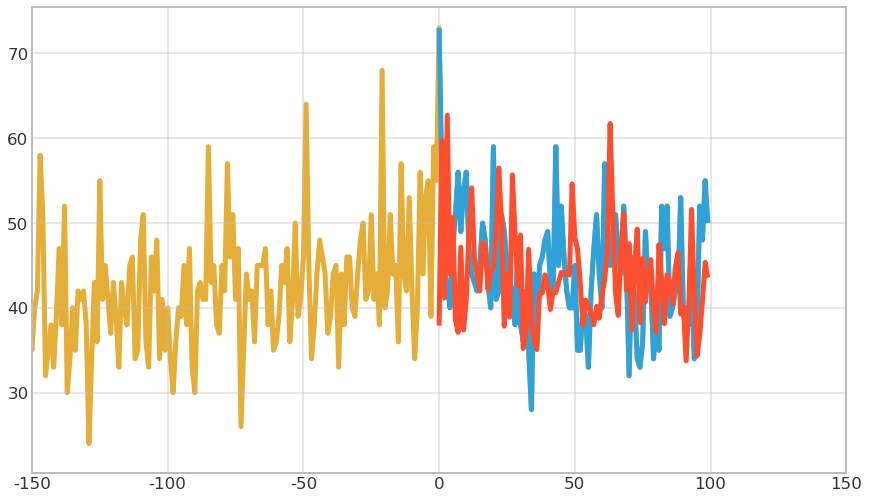

In [47]:
plt.plot(y_test)
plt.plot(y_pred)
n = len(y_pred)
t = len(df_daily_female_births)
plt.plot(np.arange(-t+n, n), df_daily_female_births.values, zorder=-10)
plt.xlim(-150, 150)
None

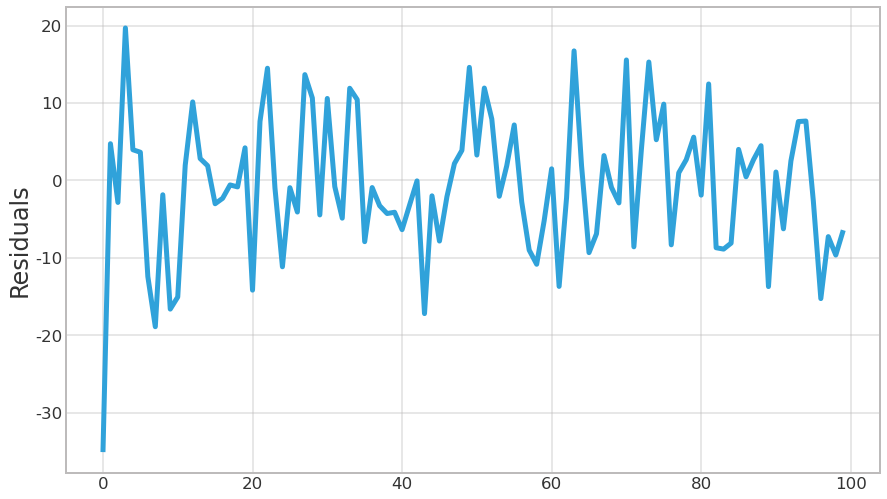

In [48]:
plt.plot(y_pred - y_test)
plt.ylabel('Residuals')
None

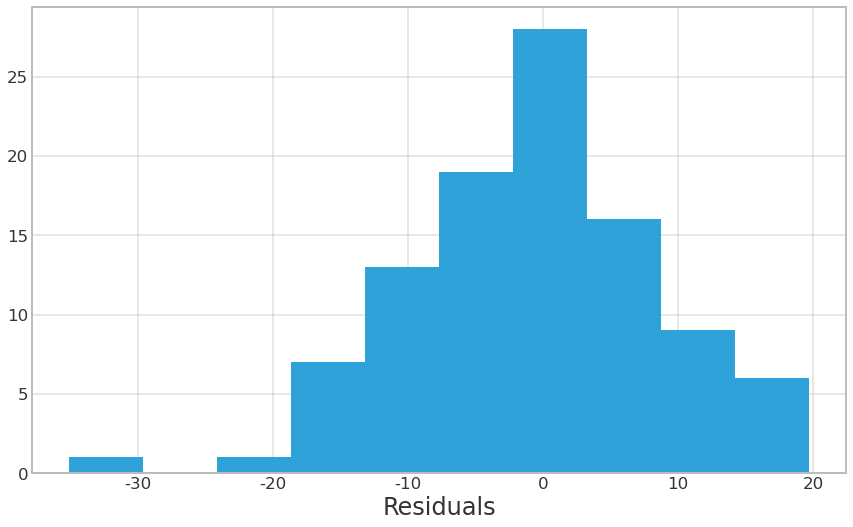

In [49]:
plt.hist(y_pred - y_test)
plt.xlabel('Residuals')
None